<a href="https://colab.research.google.com/github/stayxyz/Use-Neural-Network-to-Predict-S-P-500-Movement-Trend/blob/master/ANNs_CNNs_in_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##General Imports

In [ ]:
%tensorflow_version 2.x

In [ ]:
# General imports
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(251079926)
%matplotlib inline

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.layers import AveragePooling1D, Conv1D
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import missingno as mno

In [ ]:
print(tf.__version__)

2.2.0-rc2


In [ ]:
# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import math as math
import string
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import os
import codecs
import copy as cp
from sklearn.decomposition import PCA
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time

## Feature Dictionary 

Ticker Name | Financial Data Definition
--- | ---
GSPC | S&P 500 Index
GC = F | Gold Future 
DJI | Dow Jones Industrial Average
IXIC | NASDAQ Composite 
RUT | Russell 2000
CL=F| Crude Oil Future
EURUSD=X | EUR/USD Exchange Rate
TNX  | Treasury Yield 10 Years
GBPUSD=X | GBP/USD EXchange Rate 
S=F  | Soybeans Future
TYX | Treasury Yield 30 Years
CNYUSD=X | CNY/USD Exchange Rate
IXCO | NASDAQ Computer
MID | S&P MID CAP 400 INDEX
NDX | NASDAQ 100
NYA | NYSE COMPOSITE
RUI |RUSSELL 1000 INDEX
PSE | NYSE Arca Tech 100 Index
XAU |PHLX GOLD and SILVER SECTOR I
XAX | NYSE AMEX COMPOSITE INDEX
XSPX.L |Xtrackers S&P 500 Swap UCITS ETF 1C
SDS | ProShares UltraShort S&P500





##Data Imports

In [ ]:
! gdown  https://drive.google.com/uc?id=15XbHm_39fxSWa477p2SqKnYufQiHrWIQ
! unzip '/content/^GSPC.xlsx.zip'

Downloading...
From: https://drive.google.com/uc?id=15XbHm_39fxSWa477p2SqKnYufQiHrWIQ
To: /content/^GSPC.xlsx.zip
100% 415k/415k [00:00<00:00, 59.4MB/s]
Archive:  /content/^GSPC.xlsx.zip
replace ^GSPC.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ^GSPC.xlsx              
replace __MACOSX/._^GSPC.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._^GSPC.xlsx   


In [ ]:
Raw_data  = pd.read_excel('^GSPC.xlsx')

In [ ]:
# Checking the data shape 
Raw_data.shape 

(2517, 23)

##Data Cleaning & Feature Selection

In [ ]:
#We delete useless rows where loan amount is Null

#First we check if the Raw data has empty value 
nullset = Raw_data.isnull()
null_counts = Raw_data.isnull().sum() / len(Raw_data)
print("percentage of null values in each column:\n{}".format(null_counts.head(23)))

percentage of null values in each column:
Date        0.000000
GSPC        0.000000
GC=F        0.008741
DJI         0.000795
IXIC        0.000795
RUT         0.000795
CL=F        0.008343
EURUSD=X    0.001986
TNX         0.008741
GBPUSD=X    0.001986
S=F         0.008343
TYX         0.008741
CNYUSD=X    0.002384
IXCO        0.000795
MID         0.000795
NDX         0.000795
NYA         0.000795
RUI         0.001192
PSE         0.000795
XAU         0.001192
XAX         0.000795
XSPX.L      0.860151
SDS         0.000000
dtype: float64


Decision: any covaraites which has more than 80% missing value will be dropped, and any covariates with < 1% missing value will be replcaed with the median value 

In [ ]:
 Data = Raw_data

Here we delete 'XSPX.L' for missing 86.0151% data - 'XSPX.L' stands for Xtrackers S&P 500 Swap UCITS ETF 1C

In [ ]:
Data = Data.drop(columns = 'XSPX.L')

Define the functions to clean the data

In [ ]:
def GetTrainAndTest(ratio, Y, X):
    N = int(np.floor(len(Y) * ratio))
    data_train = pd.concat([Y[0:N], X.iloc[0:N, :]], axis = 1)
    data_test = pd.concat([Y[N:len(Y)], X.iloc[N:len(Y)]], axis = 1)
    return data_train, data_test
    
def OmitNAN(X, Y):
    for i in range(0,len(X)):
        Xsum = np.sum(X[i,:,:],1)
        idx = ~np.isnan(Xsum)
        X=X[:,idx,:]
        Y=Y[idx]
    return X, Y 

def DeleteOutlier(X, Y):
    for i in range(0,len(X)):
        Xsum = np.sum(X[i,:,:],1)
        idx = ( Xsum <= 3)
        X=X[:,idx,:]
        Y=Y[idx]
    return X, Y

def GetLags(data_train, data_test, nlags):
    end = len(data_train)
    Y_train = data_train.iloc[nlags:end, 0]
    X_train = np.zeros([nlags, end - nlags, data_train.shape[1] - 1])
    
    end = len(data_test)
    X_test = np.zeros([nlags, end - nlags, data_test.shape[1] - 1])
    Y_test = data_test.iloc[nlags:end, 0]
    for i in range (1,nlags+1):
        end = len(data_train)
        X_train[i-1,:,:] = data_train.iloc[nlags-i:end-i, 1:data_test.shape[1]]
        end = len(data_test)
        X_test[i-1,:,:] = data_test.iloc[nlags-i:end-i, 1:data_test.shape[1]]
    return X_train, Y_train, X_test, Y_test


def NormalizeFeatures(X_train,X_test):
    for i in range (0, X_train.shape[2]):
        mu = np.quantile(X_train[:, :, i], 0.5)
        temp= X_train[:,:,i] - mu
        sigma = max(np.abs(np.quantile(temp, 0.95)), np.abs(np.quantile(temp, 0.05)))
        X_train[:,:,i] = temp/sigma
        X_test[:,:,i] = (X_test[:,:,i] - mu)/sigma
    return X_train, X_test

In [ ]:
date = Data.Date
data = Data.drop(columns = 'Date')
data = np.log(data).diff(axis = 0)
MA_period = 20

In [ ]:
col_name = data.columns.tolist()
col_name.insert(0,'MAmean')
data = data.reindex(columns=col_name)
for i in range(MA_period+1, len(data)):
    data.MAmean[i-1] = np.mean(data.GSPC[i - MA_period + 1 : i])

In [ ]:
col_name = data.columns.tolist()
col_name.insert(0,'REGIME')
data = data.reindex(columns=col_name)
data.REGIME = 1
for i in range(MA_period+1, len(data)):
    if data.GSPC[i] - data.MAmean[i-1] > -0.005:
        data.REGIME[i] = data.REGIME[i] + 1
        if data.GSPC[i] - data.MAmean[i-1] > 0:
            data.REGIME[i] = data.REGIME[i] + 1
            if data.GSPC[i] - data.MAmean[i-1] > 0.005:
                data.REGIME[i] = data.REGIME[i] + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
data= data.reset_index(drop=True)

In [ ]:
temp = data.values[:, 3:data.shape[1]]
data.iloc[1:len(data), 3:data.shape[1]] = cp.deepcopy(temp[0:len(temp)-1, :])
Nlags = 3


for i in range(0,Nlags):
    col_name = data.columns.tolist()
    col_name.insert(col_name.index('GSPC') + i + 1, 'GSPC_lag' + str(i+1))
    data = data.reindex(columns=col_name)
    data['GSPC_lag' + str(i+1)][i + 1:len(data)] = data.GSPC.values[0: len(data) - i - 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
pcor = data.corr(method = 'pearson')
scor = data.corr(method = 'spearman')

In [ ]:
pcor

,REGIME,MAmean,GSPC,GSPC_lag1,GSPC_lag2,GSPC_lag3,GC=F,DJI,IXIC,RUT,CL=F,EURUSD=X,TNX,GBPUSD=X,S=F,TYX,CNYUSD=X,IXCO,MID,NDX,NYA,RUI,PSE,XAU,XAX,SDS
REGIME,1.000000,0.020652,0.802092,-0.082890,-0.032706,-0.046149,-0.004761,-0.086597,-0.073751,-0.068902,-0.028408,0.025977,-0.060351,0.017470,0.013874,-0.054912,0.009602,-0.069355,-0.071853,-0.074760,-0.081332,-0.081473,-0.066713,-0.013418,-0.041117,0.079159
MAmean,0.020652,1.000000,0.241378,0.215323,0.208687,0.182919,-0.021200,0.213466,0.210230,0.194736,0.112094,0.029773,0.163580,0.067216,0.025516,0.157201,0.021019,0.201296,0.204887,0.202236,0.210420,0.216246,0.203568,0.042046,0.173948,-0.204069
GSPC,0.802092,0.241378,1.000000,-0.060564,0.026231,-0.047778,-0.002999,-0.069510,-0.048282,-0.049570,-0.006583,0.030096,-0.010853,0.001152,0.011308,0.013159,0.017518,-0.041904,-0.047482,-0.049558,-0.052096,-0.058481,-0.045333,0.000014,-0.018282,0.056205
GSPC_lag1,-0.082890,0.215323,-0.060564,1.000000,-0.045120,0.030054,-0.035010,0.973124,0.955508,0.907930,0.386989,0.019856,0.465141,0.070850,0.164811,0.461543,-0.016613,0.893092,0.943720,0.933379,0.977193,0.998199,0.927738,0.223671,0.767246,-0.997858
GSPC_lag2,-0.032706,0.208687,0.026231,-0.045120,1.000000,-0.051958,0.037232,-0.038954,-0.032059,-0.043085,0.042866,0.149443,0.024077,0.183388,0.018458,0.033835,0.052459,-0.029581,-0.016108,-0.034675,-0.028323,-0.039921,-0.029336,0.027312,0.004940,0.046697
GSPC_lag3,-0.046149,0.182919,-0.047778,0.030054,-0.051958,1.000000,0.001881,0.041142,0.018795,0.027839,0.031078,-0.068802,0.027215,-0.021943,0.002098,0.013057,0.024390,0.007041,0.025396,0.016495,0.020534,0.029974,0.011923,0.019662,0.031225,-0.024361
GC=F,-0.004761,-0.021200,-0.002999,-0.035010,0.037232,0.001881,1.000000,-0.044069,-0.038217,-0.010359,0.131997,0.049768,-0.203132,0.044328,0.103823,-0.162932,0.005390,-0.033899,-0.018213,-0.040541,0.014180,-0.033595,-0.030610,0.605464,0.166687,0.034961
DJI,-0.086597,0.213466,-0.069510,0.973124,-0.038954,0.041142,-0.044069,1.000000,0.900909,0.856413,0.378364,0.021002,0.466227,0.069014,0.159673,0.461588,-0.012976,0.840076,0.898953,0.881022,0.953378,0.968008,0.887686,0.194519,0.740905,-0.970846
IXIC,-0.073751,0.210230,-0.048282,0.955508,-0.032059,0.018795,-0.038217,0.900909,1.000000,0.911026,0.332892,0.028004,0.431087,0.074454,0.165762,0.423310,-0.020670,0.964247,0.919513,0.987761,0.907388,0.958483,0.953092,0.202369,0.722762,-0.954043
RUT,-0.068902,0.194736,-0.049570,0.907930,-0.043085,0.027839,-0.010359,0.856413,0.911026,1.000000,0.372117,0.014946,0.450260,0.072621,0.167650,0.446884,-0.025707,0.815800,0.969457,0.844431,0.910999,0.918054,0.879455,0.238114,0.738859,-0.905329


In [ ]:
scor

,REGIME,MAmean,GSPC,GSPC_lag1,GSPC_lag2,GSPC_lag3,GC=F,DJI,IXIC,RUT,CL=F,EURUSD=X,TNX,GBPUSD=X,S=F,TYX,CNYUSD=X,IXCO,MID,NDX,NYA,RUI,PSE,XAU,XAX,SDS
REGIME,1.000000,0.008228,0.931079,-0.076895,-0.036989,-0.036393,0.009557,-0.081082,-0.070791,-0.056438,-0.021897,0.032713,-0.052627,0.017399,0.011773,-0.050857,-0.001348,-0.070858,-0.059151,-0.075713,-0.071563,-0.074652,-0.059320,-0.009745,-0.033699,0.075094
MAmean,0.008228,1.000000,0.180946,0.169507,0.167698,0.165152,-0.015935,0.172297,0.162421,0.140581,0.074859,0.025645,0.116956,0.058880,0.022339,0.108316,0.061241,0.164431,0.151094,0.160068,0.160414,0.169724,0.166097,0.034688,0.134656,-0.169675
GSPC,0.931079,0.180946,1.000000,-0.038159,-0.012100,-0.003952,0.007695,-0.042859,-0.038497,-0.028485,-0.001701,0.040252,-0.025713,0.025901,0.011175,-0.022193,0.010935,-0.038522,-0.025910,-0.043052,-0.031646,-0.036512,-0.028552,0.004838,-0.004304,0.036031
GSPC_lag1,-0.076895,0.169507,-0.038159,1.000000,-0.037011,-0.011006,-0.027757,0.948396,0.926330,0.869513,0.348473,0.030292,0.418851,0.065080,0.152351,0.410719,0.027889,0.846456,0.910897,0.896671,0.967220,0.996469,0.904461,0.197730,0.695377,-0.996803
GSPC_lag2,-0.036989,0.167698,-0.012100,-0.037011,1.000000,-0.038147,0.021733,-0.030123,-0.018523,-0.042579,0.015352,0.117634,-0.016982,0.160955,0.026640,-0.016365,0.058018,-0.008172,-0.020470,-0.014176,-0.033054,-0.033449,-0.024210,0.014504,0.000178,0.030888
GSPC_lag3,-0.036393,0.165152,-0.003952,-0.011006,-0.038147,1.000000,-0.008766,0.009346,-0.009448,-0.006125,0.005291,-0.045703,0.021645,-0.022286,0.014859,0.013986,0.072511,-0.018636,-0.016716,-0.007974,-0.019240,-0.011370,-0.015790,-0.008727,-0.013574,0.009559
GC=F,0.009557,-0.015935,0.007695,-0.027757,0.021733,-0.008766,1.000000,-0.047237,-0.033269,-0.010813,0.147350,0.009880,-0.226491,0.019897,0.100133,-0.192753,-0.024320,-0.030825,-0.019760,-0.040915,0.017895,-0.026140,-0.036207,0.605314,0.173340,0.027287
DJI,-0.081082,0.172297,-0.042859,0.948396,-0.030123,0.009346,-0.047237,1.000000,0.830270,0.795977,0.334894,0.035970,0.426910,0.065605,0.149071,0.420668,0.035939,0.758324,0.843778,0.804495,0.933008,0.939732,0.835011,0.161846,0.659204,-0.944999
IXIC,-0.070791,0.162421,-0.038497,0.926330,-0.018523,-0.009448,-0.033269,0.830270,1.000000,0.878679,0.293387,0.035943,0.385311,0.062415,0.145971,0.371767,0.023550,0.947014,0.877513,0.981121,0.856349,0.931857,0.942398,0.184285,0.643929,-0.924827
RUT,-0.056438,0.140581,-0.028485,0.869513,-0.042579,-0.006125,-0.010813,0.795977,0.878679,1.000000,0.344636,0.031714,0.395760,0.065754,0.153159,0.387480,0.013108,0.762432,0.955941,0.791931,0.871910,0.885031,0.850741,0.210016,0.667482,-0.867190


In [ ]:
temp = np.array(data.iloc[2:len(data),7:10])
temp[np.isnan(temp)] = 0
pca = PCA(n_components = 3)
PCA1 = pca.fit_transform(temp)[:,0]

In [ ]:
col_name = data.columns.tolist()
col_name.insert(col_name.index('DJI'),'PCA1')
data = data.reindex(columns=col_name)
data.PCA1[2:len(data)] = PCA1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
pca.fit_transform(temp)

array([[ 0.00084522, -0.00120768,  0.00082916],
       [ 0.00331003, -0.00259686,  0.00197969],
       [-0.01027797,  0.00104867, -0.0006036 ],
       ...,
       [ 0.05915808,  0.00823817, -0.00595889],
       [ 0.02961117, -0.00255311,  0.00352617],
       [ 0.14801854,  0.00491424, -0.01466323]])

In [ ]:
Regime = data.REGIME[21:len(data)].reset_index(drop=True)
GSPC = data.GSPC[21:len(data)].reset_index(drop=True)
X = data.loc[21:len(data), ['GSPC_lag1', 'GSPC_lag2', 'GSPC_lag3', 'DJI', 'RUI']].reset_index(drop=True)

In [ ]:
Nlags = 3
data_train, data_test = GetTrainAndTest(2/3, Regime, X)
X_train, Y_train, X_test, Y_test = GetLags(data_train, data_test,Nlags)

X_train, Y_train = OmitNAN(X_train, Y_train)
Y_train -= 1
X_test, Y_test = OmitNAN(X_test, Y_test)
Y_test -= 1
X_train, X_test = NormalizeFeatures(X_train, X_test)

X_train, Y_train = DeleteOutlier(X_train, Y_train)
X_test, Y_test = DeleteOutlier(X_test, Y_test)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# data for train and test
X_train_gpu = torch.from_numpy(X_train).float().to(device)
X_test_gpu = torch.from_numpy(X_test).float().to(device)
Y_train_gpu = torch.from_numpy(Y_train.values).long().to(device)
Y_test_gpu = torch.from_numpy(Y_test.values).long().to(device)

# RNN with GRU 


In [ ]:
def GetMiniBatchRandPerm(X, y, n):
    idx = np.random.permutation(n)
    return X[:,idx[0:n],:], y[idx[0:n]]

class RegimeGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_lags, batch_size, output_dim=1, num_layers=2):
        super(RegimeGRU,self).__init__()
        self.input_dim = input_dim # # of features
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.n_lags = n_lags
        # Defeine the GRU layer
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers)
        
        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # initialise hidden state
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
    
    def forward(self,x):
        self.batch_size = x.size(1)
        self.hidden = self.init_hidden() # initialize hidden state
        
        with torch.no_grad():
            gru_out, self.hidden = self.gru(x, self.hidden)
        y_pred = self.fc(gru_out[-1])
        return y_pred


In [ ]:
def RunGRU(model, optimizer, criterion, num_epochs, BatchSize, X_train_gpu, Y_train_gpu, X_test_gpu, Y_test):
    loss_hist = np.zeros(num_epochs) # record error of every epoch
    model.hidden = model.init_hidden()

    start_time = time.time()
    for t in range(num_epochs):
        X_gpu, Y_gpu = GetMiniBatchRandPerm(X_train_gpu, Y_train_gpu, BatchSize)
    # reset hidden states
        optimizer.zero_grad()
    # forward
        output = model(X_gpu)
    # backward
    
        loss = criterion(output, Y_gpu)
        loss.backward()

    # optimize
        optimizer.step()
        loss_hist[t] = loss.item()

    # print and restore loss
        output = model(X_test_gpu)
        ypred=np.argmax(output.detach().cpu().numpy(),1)
        accuracy = sum(Y_test==ypred)/len(ypred)
      
        if (t+1)% 500 == 0:
            print("Epoch:{:0>4d}, CrossEntropy:{:<10.9f}".format(t,loss.item()))
            print('============')
        # plot loss so far
            plt.plot(loss_hist[0:t])
            plt.show()
            end_time = time.time()

        #print time of processing
            print(end_time - start_time)
            start_time = time.time()
        # show the current prediction accuracy
            output = model(X_test_gpu)
            
            print(accuracy) 
            
    return  model, accuracy, ypred

Epoch:0499, CrossEntropy:1.364358068


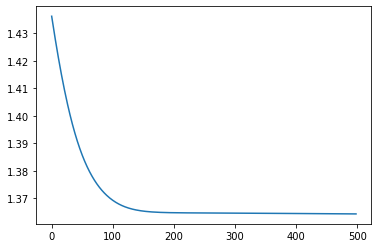

2.4263858795166016
0.36421319796954316
Epoch:0999, CrossEntropy:1.363331437


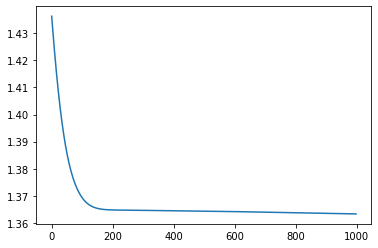

2.447267532348633
0.36548223350253806
Epoch:1499, CrossEntropy:1.361926198


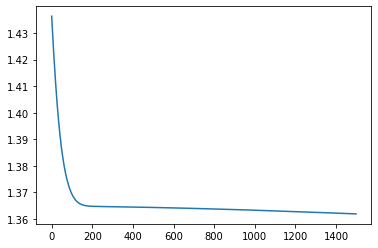

2.4941656589508057
0.3730964467005076
Epoch:1999, CrossEntropy:1.360205889


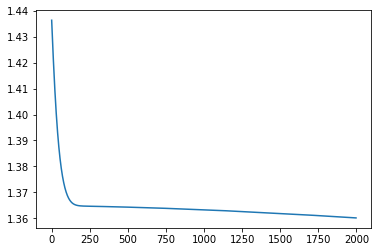

2.4684641361236572
0.383248730964467
Epoch:2499, CrossEntropy:1.358238697


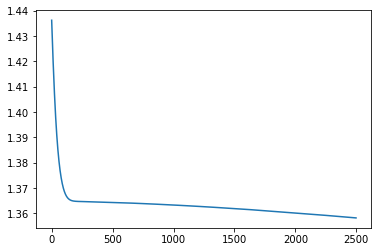

2.484100818634033
0.39213197969543145
Epoch:2999, CrossEntropy:1.356102347


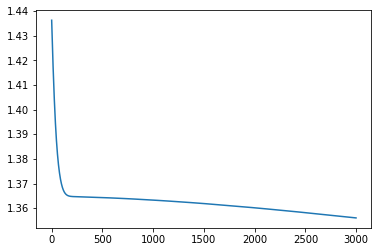

2.4812536239624023
0.3883248730964467
Epoch:3499, CrossEntropy:1.353883147


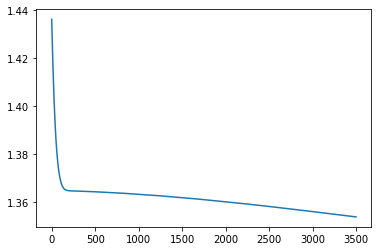

2.4467689990997314
0.39086294416243655
Epoch:3999, CrossEntropy:1.351664782


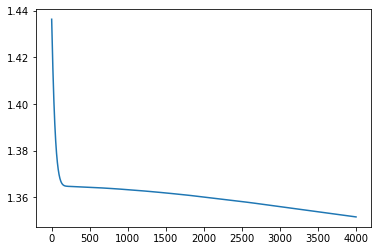

2.489062786102295
0.39086294416243655
Epoch:4499, CrossEntropy:1.349523067


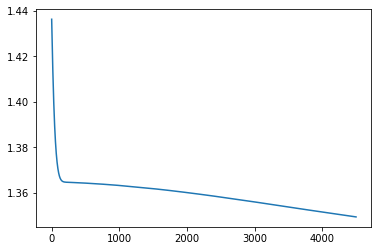

2.471238851547241
0.3895939086294416
Epoch:4999, CrossEntropy:1.347516775


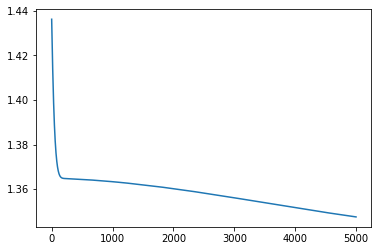

2.4307563304901123
0.39213197969543145


In [ ]:
BatchSize = 150
# initialize the model
#(self, input_dim, hidden_dim, n_lags, batch_size, output_dim=1, num_layers=2):
model = RegimeGRU(input_dim = 5, hidden_dim = 3, n_lags = Nlags, batch_size = BatchSize, output_dim = 4, num_layers = 3).to(device)



# define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# training
num_epochs = 5000
model, accuracy, ypred= \
RunGRU(model, optimizer, criterion, num_epochs, BatchSize, X_train_gpu, Y_train_gpu, X_test_gpu, Y_test)

Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = Y_test, y_pred = ypred)

array([[ 15,  93,   0,  26],
       [ 13, 250,   0,  16],
       [ 16, 184,   0,  20],
       [ 10, 101,   0,  44]])

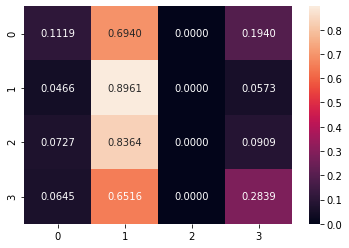

In [ ]:
confusion_matrix_plot = confusion_matrix(y_true = Y_test, y_pred = ypred).astype('float') / confusion_matrix(y_true = Y_test, y_pred = ypred).sum(axis = 1)[:, np.newaxis]

df_confusion_matrix = pd.DataFrame(confusion_matrix_plot, index = ["0","1","2","3"], columns = ["0","1","2","3"])

heatmap = sns.heatmap(df_confusion_matrix, annot=True, fmt= '.4f')

# Simple 1D CNN As Control Group 

In [ ]:
import copy as cp
from sklearn.decomposition import PCA
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time


def GetMiniBatchRandPerm(X, y, n):
    idx = np.random.permutation(n)
    return X[:,idx[0:n],:], y[idx[0:n]]

class RegimeGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_lags, batch_size, output_dim=1, num_layers=2):
        super(RegimeGRU,self).__init__()
        self.input_dim = input_dim # # of features
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.n_lags = n_lags
        # Defeine the GRU layer
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers)
        
        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # initialise hidden state
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
    
    def forward(self,x):
        self.batch_size = x.size(1)
        self.hidden = self.init_hidden() # initialize hidden state
        
        with torch.no_grad():
            gru_out, self.hidden = self.gru(x, self.hidden)
        y_pred = self.fc(gru_out[-1])
        return y_pred
    
def GetTrainAndTest(ratio, Y, X):
    N = int(np.floor(len(Y) * ratio))
    data_train = pd.concat([Y[0:N], X.iloc[0:N, :]], axis = 1)
    data_test = pd.concat([Y[N:len(Y)], X.iloc[N:len(Y)]], axis = 1)
    return data_train, data_test
    
def OmitNAN(X, Y):
    for i in range(0,len(X)):
        Xsum = np.sum(X[i,:,:],1)
        idx = ~np.isnan(Xsum)
        X=X[:,idx,:]
        Y=Y[idx]
    return X, Y 

def DeleteOutlier(X, Y):
    for i in range(0,len(X)):
        Xsum = np.sum(X[i,:,:],1)
        idx = ( Xsum <= 3)
        X=X[:,idx,:]
        Y=Y[idx]
    return X, Y

def GetLags(data_train, data_test, nlags):
    end = len(data_train)
    Y_train = data_train.iloc[nlags:end, 0]
    X_train = np.zeros([nlags, end - nlags, data_train.shape[1] - 1])
    
    end = len(data_test)
    X_test = np.zeros([nlags, end - nlags, data_test.shape[1] - 1])
    Y_test = data_test.iloc[nlags:end, 0]
    for i in range (1,nlags+1):
        end = len(data_train)
        X_train[i-1,:,:] = data_train.iloc[nlags-i:end-i, 1:data_test.shape[1]]
        end = len(data_test)
        X_test[i-1,:,:] = data_test.iloc[nlags-i:end-i, 1:data_test.shape[1]]
    return X_train, Y_train, X_test, Y_test


def NormalizeFeatures(X_train,X_test):
    for i in range (0, X_train.shape[2]):
        mu = np.quantile(X_train[:, :, i], 0.5)
        temp= X_train[:,:,i] - mu
        sigma = max(np.abs(np.quantile(temp, 0.95)), np.abs(np.quantile(temp, 0.05)))
        X_train[:,:,i] = temp/sigma
        X_test[:,:,i] = (X_test[:,:,i] - mu)/sigma
    return X_train, X_test


def RunGRU(model, optimizer, criterion, num_epochs, BatchSize, X_train_gpu, Y_train_gpu, X_test_gpu, Y_test):
    loss_hist = np.zeros(num_epochs) # record error of every epoch
    model.hidden = model.init_hidden()

    start_time = time.time()
    for t in range(num_epochs):
        X_gpu, Y_gpu = GetMiniBatchRandPerm(X_train_gpu, Y_train_gpu, BatchSize)
    # reset hidden states
        optimizer.zero_grad()
    # forward
        output = model(X_gpu)
    # backward
    
        loss = criterion(output, Y_gpu)
        loss.backward()

    # optimize
        optimizer.step()    
        loss_hist[t] = loss.item()

    # print and restore loss
        output = model(X_test_gpu)
        ypred=np.argmax(output.detach().cpu().numpy(),1)
        accuracy = sum(Y_test==ypred)/len(ypred)
        
        if (t+1)% 500 == 0:
            print("Epoch:{:0>4d}, CrossEntropy:{:<10.9f}".format(t,loss.item()))
            print('============')
        # plot loss so far
            plt.plot(loss_hist[0:t])
            plt.show()
            end_time = time.time()

        #print time of processing
            print(end_time - start_time)
            start_time = time.time()
        # show the current prediction accuracy
            output = model(X_test_gpu)
            
            print(accuracy) 
            
    return  model, accuracy


MA_period = 20
Data = pd.read_excel('^GSPC.xlsx')
date = Data.Date
data = Data.drop(columns = 'Date')
data = np.log(data).diff(axis = 0)

col_name = data.columns.tolist()
col_name.insert(0,'MAmean')
data = data.reindex(columns=col_name)
for i in range(MA_period+1, len(data)):
    data.MAmean[i-1] = np.mean(data.GSPC[i - MA_period + 1 : i])

col_name = data.columns.tolist()
col_name.insert(0,'REGIME')
data = data.reindex(columns=col_name)
data.REGIME = 1
for i in range(MA_period+1, len(data)):
    if data.GSPC[i] - data.MAmean[i-1] > -0.005:
        data.REGIME[i] = data.REGIME[i] + 1
        if data.GSPC[i] - data.MAmean[i-1] > 0:
            data.REGIME[i] = data.REGIME[i] + 1
            if data.GSPC[i] - data.MAmean[i-1] > 0.005:
                data.REGIME[i] = data.REGIME[i] + 1
    

temp = data.values[:, 3:data.shape[1]]
data.iloc[1:len(data), 3:data.shape[1]] = cp.deepcopy(temp[0:len(temp)-1, :])
Nlags = 3

for i in range(0,Nlags):
    col_name = data.columns.tolist()
    col_name.insert(col_name.index('GSPC') + i + 1, 'GSPC_lag' + str(i+1))
    data = data.reindex(columns=col_name)
    data['GSPC_lag' + str(i+1)][i + 1:len(data)] = data.GSPC.values[0: len(data) - i - 1]

data = data.drop(columns = 'XSPX.L')

pcor = data.corr(method = 'pearson')
scor = data.corr(method = 'spearman')



Regime = data.REGIME[21:len(data)].reset_index(drop=True)
GSPC = data.GSPC[21:len(data)].reset_index(drop=True)
X = data.loc[21:len(data), ['GSPC_lag1', 'GSPC_lag2', 'GSPC_lag3', 'DJI', 'RUI']].reset_index(drop=True)


Nlags = 5
data_train, data_test = GetTrainAndTest(2/3, Regime, X)
X_train, Y_train, X_test, Y_test = GetLags(data_train, data_test,Nlags)

X_train, Y_train = OmitNAN(X_train, Y_train)
Y_train -= 1
X_test, Y_test = OmitNAN(X_test, Y_test)
Y_test -= 1
X_train, X_test = NormalizeFeatures(X_train, X_test)

X_train, Y_train = DeleteOutlier(X_train, Y_train)
X_test, Y_test = DeleteOutlier(X_test, Y_test)


model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=2))


model.add(Flatten())


model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))


model.add(Dense(1, activation = 'softmax'))

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['acc'])

X_train = X_train.swapaxes(0,1)
model.fit(X_train, Y_train.values, validation_split=0.33, epochs=30, batch_size=150)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:174: SettingWithCopyWarning: 
A value is trying 

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

7/7 [==============================] - 0s 57ms/step - loss: 0.0000e+00 - acc: 0.2797 - val_loss: 0.0000e+00 - val_acc: 0.2914
Epoch 2/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - acc: 0.2797 - val_loss: 0.0000e+00 - val_acc: 0.2914
Epoch 3/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - acc: 0.2797 - val_loss: 0.0000e+00 - val_acc: 0.2914
Epoch 4/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - acc: 0.2797 - va

Confusion Matrix

In [ ]:
X_test = X_test.swapaxes(0,1)

In [ ]:
cnn_y_pred = model.predict_classes(X_test,verbose = 1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
24/24 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = Y_test, y_pred = cnn_y_pred)

array([[  0, 129,   0,   0],
       [  0, 275,   0,   0],
       [  0, 216,   0,   0],
       [  0, 145,   0,   0]])

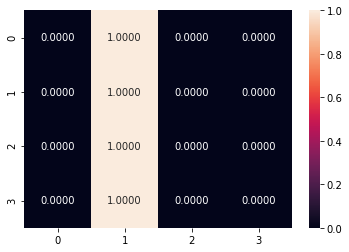

In [ ]:
confusion_matrix_plot = confusion_matrix(y_true = Y_test, y_pred = cnn_y_pred).astype('float') / confusion_matrix(y_true = Y_test, y_pred = cnn_y_pred).sum(axis = 1)[:, np.newaxis]

df_confusion_matrix = pd.DataFrame(confusion_matrix_plot, index = ["0","1","2","3"], columns = ["0","1","2","3"])

heatmap = sns.heatmap(df_confusion_matrix, annot=True, fmt= '.4f')

# Naive Methods

##1. Random Number Method 

Since there are 4 categories, the chance to predict the correct category is 25

##2. Focus on the Most Frequent Movement Category 

In [ ]:
Y_train.value_counts() / len(Y_train)

1    0.283528
0    0.240525
2    0.239067
3    0.236880
Name: REGIME, dtype: float64

In [ ]:
accuarcy = np.count_nonzero(Y_test == 2) / len(Y_test)

In [ ]:
accuarcy

0.2823529411764706

In [ ]:
Y_test = Y_test.to_list()

##3. Naive Method for Markov Chain Prediction  

In [ ]:
prediction_list = []
def Naive_Markov (x):
  initial_start = x[0]
  naive_guess = initial_start
  for element in x[1:]: 
    if naive_guess == element:
      prediction_list.append(naive_guess)
    else:
      prediction_list.append(naive_guess)
      naive_guess = element

In [ ]:
Naive_Markov(Y_test)

In [ ]:
len(prediction_list)
len(Y_test)

765

In [ ]:
def matching (list1, list2):
  result = []
  assert len(list1) == len(list2), "lists should have same length"
  for i in range(0, len(list1)-1):
    if list1[i] == list2[i]:
      result.append(True)
    else:
      result.append(False)
  return result


In [ ]:
Y_test[1:6]

[2, 0, 1, 1, 0]

In [ ]:
prediction_list[0:5]

[1, 2, 0, 1, 1]

In [ ]:
match_result = matching(Y_test[1:], prediction_list)
matches = match_result.count(True)
accuarcy = matches / len(Y_test)

In [ ]:
accuarcy

0.2928104575163399

In [ ]:
confusion_matrix(y_true = Y_test[1:], y_pred = prediction_list)

array([[ 27,  39,  40,  23],
       [ 33, 106,  88,  47],
       [ 31,  87,  57,  41],
       [ 37,  43,  31,  34]])